# The objective of the model is to build VAE that can generate new faces by drawing latent vectors from the prior distribution.

#Loading Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# PyTorch is a Python package that provides two high-level features:
# Tensor computation with strong GPU acceleration and Deep neural networks built

import argparse
import os
import random
import torch
import torchvision


#The module torch. nn contains different classess that help you build neural network models.
import torch.nn as nn
import torch.nn.parallel

#PyTorch provides two data primitives: torch.utils.data.
#DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data.
import torch.optim as optim
import torch.utils.data

#torchvision package consists of popular datasets, model architectures,
#and common image transformations for computer vision

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.utils.data import DataLoader


#NumPy support for large, multi-dimensional arrays and matrices

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#Imageio to read and write a wide range of image data, including animated images, video, volumetric data
import imageio




# Loading dataset

DataSet

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image

In [3]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/GenAIBOOK/celeba"
# Batch size during training
batch = 128
# Spatial size of training images. All images will be resized to this size
img_size = 64

In [16]:
image_mean = [0.485, 0.456, 0.406]  # mean of the  dataset for normalizing
image_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing

dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize(image_mean,image_std),
                           ]))
train_samples = int(0.8 * len(dataset))
val_samples = len(dataset) - train_samples
train_set, val_set = torch.utils.data.random_split(dataset, [train_samples, val_samples]) # check len(dataset) prior splitting

# Create the dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch,shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch,shuffle=True, num_workers=2)

print(len(train_loader.dataset))
print(len(val_loader.dataset))


9103
2276


#Visualization

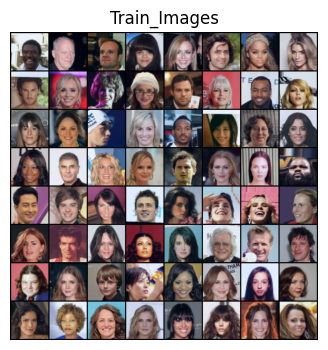

In [15]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
# Plot train_images
real_batch = next(iter(train_loader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Train_Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#Model

In [17]:
import torch.nn as nn
import torch.nn.functional as F
in_chn = 64 # initial number of filters
img_chn = 3 # color channels
latent_dim = 128 # number of features to consider
# define a Conv VAE
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # encoder
        self.e1 = nn.Conv2d(
            in_channels=img_chn, out_channels=in_chn,
            kernel_size=4, stride=2, padding=2
        )
        self.e2 = nn.Conv2d(
            in_channels=in_chn, out_channels=in_chn*2,
            kernel_size=4, stride=2, padding=2
        )
        self.e3 = nn.Conv2d(
            in_channels=in_chn*2, out_channels=in_chn*4,
            kernel_size=4, stride=2, padding=2
        )
        self.e4 = nn.Conv2d(
            in_channels=in_chn*4, out_channels=in_chn*8,
            kernel_size=4, stride=2, padding=2
        )
        self.e5 = nn.Conv2d(
            in_channels=in_chn*8, out_channels=1024,
            kernel_size=4, stride=2, padding=2
        )
        self.fc_1 = nn.Linear(1024, 2048)
        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_var = nn.Linear(2048, latent_dim)
        self.fc_2 = nn.Linear(latent_dim, 1024)
        # decoder
        self.d1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=in_chn*8,
            kernel_size=3, stride=2
        )
        self.d2 = nn.ConvTranspose2d(
            in_channels=in_chn*8, out_channels=in_chn*4,
            kernel_size=3, stride=2
        )
        self.d3 = nn.ConvTranspose2d(
            in_channels=in_chn*4, out_channels=in_chn*2,
            kernel_size=3, stride=2
        )
        self.d4 = nn.ConvTranspose2d(
            in_channels=in_chn*2, out_channels=in_chn,
            kernel_size=3, stride=2
        )
        self.d5 = nn.ConvTranspose2d(
            in_channels=in_chn, out_channels=img_chn,
            kernel_size=4, stride=2
        )
    def reparameterize(self, mu, var):
        """
        :param mu: mean from the encoder's latent space
        :param var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def forward(self, x):
        # encoding
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        x = F.relu(self.e3(x))
        x = F.relu(self.e4(x))
        x = F.relu(self.e5(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc_1(x)
        # get `mu` and `var`
        mu = self.fc_mu(hidden)
        var = self.fc_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, var)
        z = self.fc_2(z)
        z = z.view(-1, 1024, 1, 1)

        # decoding
        x = F.relu(self.d1(z))
        x = F.relu(self.d2(x))
        x = F.relu(self.d3(x))
        x = F.relu(self.d4(x))
        reconstruction = torch.sigmoid(self.d5(x))
        return reconstruction, mu, var

In [39]:
import torch.optim as optim
# initialize the model
model = ConvVAE().to(device)
# define the learning parameters
lr = 0.0001
epochs = 40
batch = 128
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

#Loss function

In [40]:
from tqdm import tqdm
import torch
def final_loss(mse_loss, mu, logvar):
    """
    This function will add the reconstruction loss (MSELoss) and the
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    """
    MSE = mse_loss

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch * 784

    return MSE + KLD

#Training

In [41]:

to_pil_image = transforms.ToPILImage()
os.mkdir("/content/drive/MyDrive/GenAIBOOK/celeba/output")
def to_pil(images):
    imgs = [np.array(to_pil_image(img)) for img in images]
    imageio.mimsave('/content/drive/MyDrive/GenAIBOOK/celeba/output/generated_images.gif', imgs)

def save_img_recon(recon_images, epoch):
    save_image(recon_images.cpu(), f"/content/drive/MyDrive/GenAIBOOK/celeba/output/output{epoch}.jpg")
def loss_plot(train_loss, valid_loss):
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='Blue', label='train loss')
    plt.plot(valid_loss, color='Green', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/GenAIBOOK/celeba/output/loss.jpg')
    plt.show()

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/GenAIBOOK/celeba/output'

In [34]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    exec_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data,_ = data
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        MSE_loss = criterion(reconstruction, data)
        print(MSE_loss)
        loss = final_loss(MSE_loss, mu, logvar)
        loss.backward()
        exec_loss += loss.item()
        optimizer.step()
    train_loss = exec_loss / counter
    return train_loss

In [42]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    exec_loss = 0.0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data,_= data
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            MSE_loss = criterion(reconstruction, data)
            loss = final_loss(MSE_loss, mu, logvar)
            exec_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(dataset)/dataloader.batch_size) - 1:
                recon_images = reconstruction
    val_loss = exec_loss / counter
    return val_loss, recon_images

In [37]:
from torchvision.utils import make_grid
# a list to save all the reconstructed images in PyTorch grid format
grid_images = []
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, train_set, device, optimizer, criterion
    )
    valid_epoch_loss, recon_images = validate(
        model, val_loader, val_set, device, criterion
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    # save the reconstructed images from the validation loop
    save_img_recon(recon_images, epoch+1)
    #convert the reconstructed images to PyTorch image grid format
    image_grid = make_grid(recon_images.detach().cpu())
    grid_images.append(image_grid)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")


Epoch 1 of 10


  1%|▏         | 1/71 [00:00<01:08,  1.03it/s]

tensor(1.4399, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 2/71 [00:01<00:34,  1.99it/s]

tensor(1.4282, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:36,  1.86it/s]

tensor(1.5259, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4511, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:32,  2.03it/s]

tensor(1.4872, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4700, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:30,  2.12it/s]

tensor(1.3686, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4403, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:40,  1.52it/s]

tensor(1.4644, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4579, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:06<00:40,  1.47it/s]

tensor(1.4185, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3657, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:07<00:38,  1.51it/s]

tensor(1.4692, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4690, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:08<00:33,  1.69it/s]

tensor(1.4529, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4697, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:09<00:29,  1.86it/s]

tensor(1.3103, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4583, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:25,  2.05it/s]

tensor(1.4430, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4392, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:22,  2.25it/s]

tensor(1.3082, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4321, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:11<00:20,  2.31it/s]

tensor(1.5061, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4590, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:12<00:19,  2.31it/s]

tensor(1.4189, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3870, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:19,  2.27it/s]

tensor(1.3865, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4326, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:18,  2.22it/s]

tensor(1.4866, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4337, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:17,  2.31it/s]

tensor(1.5014, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4028, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:16,  2.32it/s]

tensor(1.4538, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4453, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:16<00:15,  2.25it/s]

tensor(1.3765, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4749, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:14,  2.27it/s]

tensor(1.5996, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4300, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:14,  2.26it/s]

tensor(1.3843, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4040, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:16,  1.79it/s]

tensor(1.3893, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3883, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:16,  1.66it/s]

tensor(1.4220, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4736, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:21<00:17,  1.52it/s]

tensor(1.3709, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3931, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:22<00:13,  1.72it/s]

tensor(1.4189, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3864, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:11,  1.96it/s]

tensor(1.4288, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3697, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:23<00:09,  2.05it/s]

tensor(1.4070, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3758, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:24<00:08,  2.22it/s]

tensor(1.3321, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3614, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:25<00:07,  2.20it/s]

tensor(1.4355, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4318, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:26<00:06,  2.17it/s]

tensor(1.4613, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4031, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:27<00:05,  2.14it/s]

tensor(1.3387, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4167, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:04,  2.15it/s]

tensor(1.3702, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4713, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.14it/s]

tensor(1.4766, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3075, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:02,  2.21it/s]

tensor(1.4376, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3584, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:01,  2.30it/s]

tensor(1.3737, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4304, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.38it/s]

tensor(1.4220, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4132, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.28it/s]                        

tensor(1.4428, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2047, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:08,  2.14it/s]                        

Train Loss: 1.4335
Val Loss: 1.4097
Epoch 2 of 10



  1%|▏         | 1/71 [00:00<01:05,  1.07it/s]

tensor(1.3347, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4060, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:38,  1.77it/s]

tensor(1.3343, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2905, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:32,  2.03it/s]

tensor(1.4116, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3406, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:30,  2.10it/s]

tensor(1.3072, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2582, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:27,  2.24it/s]

tensor(1.3265, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4608, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:04<00:26,  2.28it/s]

tensor(1.3246, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3801, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:05<00:27,  2.07it/s]

tensor(1.3396, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 14/71 [00:06<00:24,  2.34it/s]

tensor(1.3350, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:07<00:31,  1.76it/s]

tensor(1.3548, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 16/71 [00:07<00:27,  2.00it/s]

tensor(1.3574, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:08<00:32,  1.67it/s]

tensor(1.3974, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 18/71 [00:08<00:27,  1.89it/s]

tensor(1.3360, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:30,  1.69it/s]

tensor(1.2443, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 20/71 [00:09<00:25,  2.01it/s]

tensor(1.3652, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:24,  2.01it/s]

tensor(1.3499, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 22/71 [00:10<00:21,  2.25it/s]

tensor(1.3137, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:22,  2.15it/s]

tensor(1.3307, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 24/71 [00:11<00:19,  2.37it/s]

tensor(1.3780, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:20,  2.23it/s]

tensor(1.3074, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 26/71 [00:12<00:17,  2.50it/s]

tensor(1.4212, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:19,  2.27it/s]

tensor(1.2999, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 28/71 [00:12<00:17,  2.52it/s]

tensor(1.2981, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:17,  2.42it/s]

tensor(1.3410, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 30/71 [00:13<00:16,  2.47it/s]

tensor(1.3312, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:16,  2.45it/s]

tensor(1.4044, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 32/71 [00:14<00:16,  2.41it/s]

tensor(1.3097, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:14<00:15,  2.43it/s]

tensor(1.3443, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 34/71 [00:15<00:15,  2.41it/s]

tensor(1.3493, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:15<00:14,  2.50it/s]

tensor(1.3124, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 36/71 [00:16<00:15,  2.33it/s]

tensor(1.1886, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:12,  2.75it/s]

tensor(1.3003, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 38/71 [00:17<00:14,  2.31it/s]

tensor(1.2499, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:12,  2.66it/s]

tensor(1.2344, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 40/71 [00:17<00:13,  2.30it/s]

tensor(1.2632, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:11,  2.71it/s]

tensor(1.3333, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 42/71 [00:18<00:12,  2.35it/s]

tensor(1.3518, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:18<00:10,  2.60it/s]

tensor(1.2962, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 44/71 [00:19<00:12,  2.19it/s]

tensor(1.2675, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:20<00:11,  2.21it/s]

tensor(1.2194, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 46/71 [00:20<00:13,  1.86it/s]

tensor(1.2300, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:21<00:12,  1.90it/s]

tensor(1.2819, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:22<00:14,  1.63it/s]

tensor(1.2492, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:12,  1.81it/s]

tensor(1.2599, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 50/71 [00:23<00:12,  1.68it/s]

tensor(1.3646, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:23<00:10,  1.89it/s]

tensor(1.2764, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 52/71 [00:23<00:09,  1.98it/s]

tensor(1.2198, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:24<00:08,  2.14it/s]

tensor(1.2331, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:24<00:07,  2.20it/s]

tensor(1.3476, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:25<00:07,  2.29it/s]

tensor(1.2346, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 56/71 [00:25<00:06,  2.33it/s]

tensor(1.2758, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:05,  2.43it/s]

tensor(1.2561, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 58/71 [00:26<00:05,  2.35it/s]

tensor(1.2730, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:04,  2.48it/s]

tensor(1.1991, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 60/71 [00:27<00:04,  2.30it/s]

tensor(1.2542, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:03,  2.52it/s]

tensor(1.2980, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 62/71 [00:28<00:03,  2.30it/s]

tensor(1.2472, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.50it/s]

tensor(1.2305, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:28<00:03,  2.27it/s]

tensor(1.2478, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:02,  2.45it/s]

tensor(1.2416, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 66/71 [00:29<00:02,  2.29it/s]

tensor(1.2285, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:01,  2.58it/s]

tensor(1.2579, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 68/71 [00:30<00:01,  2.24it/s]

tensor(1.3092, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.59it/s]

tensor(1.2633, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 70/71 [00:31<00:00,  2.29it/s]

tensor(1.2261, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1747, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.27it/s]                        

tensor(1.1908, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:08,  2.18it/s]

Train Loss: 1.3200
Val Loss: 1.2575
Epoch 3 of 10



  1%|▏         | 1/71 [00:00<01:07,  1.03it/s]

tensor(1.2170, device='cuda:0', grad_fn=<MseLossBackward0>)


  3%|▎         | 2/71 [00:01<00:34,  2.01it/s]

tensor(1.1155, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:34,  1.96it/s]

tensor(1.2373, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2411, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:31,  2.08it/s]

tensor(1.2367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1494, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:29,  2.19it/s]

tensor(1.2303, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2929, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:28,  2.21it/s]

tensor(1.1831, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2339, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:04<00:27,  2.22it/s]

tensor(1.2440, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2307, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:05<00:24,  2.39it/s]

tensor(1.2832, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2395, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:06<00:27,  2.06it/s]

tensor(1.1630, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2371, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:08<00:40,  1.32it/s]

tensor(1.1958, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2008, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:38,  1.36it/s]

tensor(1.2810, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2634, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:35,  1.40it/s]

tensor(1.3002, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2119, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:11<00:28,  1.67it/s]

tensor(1.2928, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1815, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:12<00:23,  1.95it/s]

tensor(1.1590, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2336, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:13<00:21,  2.07it/s]

tensor(1.2529, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2185, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:14<00:18,  2.21it/s]

tensor(1.2584, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2246, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:17,  2.23it/s]

tensor(1.2600, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2001, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:17,  2.15it/s]

tensor(1.2045, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2925, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:16<00:16,  2.21it/s]

tensor(1.2018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2324, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:17<00:15,  2.22it/s]

tensor(1.1431, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2439, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:18<00:14,  2.22it/s]

tensor(1.1611, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2545, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:13,  2.16it/s]

tensor(1.2087, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2839, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:12,  2.27it/s]

tensor(1.2433, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2090, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:20<00:11,  2.27it/s]

tensor(1.2060, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2044, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:21<00:10,  2.25it/s]

tensor(1.1719, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:21<00:09,  2.50it/s]

tensor(1.2239, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:11,  1.85it/s]

tensor(1.2103, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2022, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:23<00:11,  1.67it/s]

tensor(1.2093, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2435, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:24<00:10,  1.64it/s]

tensor(1.2006, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:24<00:08,  2.02it/s]

tensor(1.1328, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:25<00:08,  1.86it/s]

tensor(1.2344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2837, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:26<00:06,  2.06it/s]

tensor(1.1987, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2116, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:27<00:05,  2.22it/s]

tensor(1.2414, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2821, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:04,  2.23it/s]

tensor(1.2742, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2311, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.30it/s]

tensor(1.2089, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:28<00:02,  2.73it/s]

tensor(1.2474, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:02,  2.26it/s]

tensor(1.1851, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2130, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:01,  2.27it/s]

tensor(1.2062, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1682, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:31<00:00,  2.38it/s]

tensor(1.1706, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 70/71 [00:31<00:00,  2.69it/s]

tensor(1.1949, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.26it/s]                        

tensor(1.2855, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3219, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:08,  2.23it/s]                        

Train Loss: 1.2478
Val Loss: 1.2390
Epoch 4 of 10



  1%|▏         | 1/71 [00:00<01:05,  1.07it/s]

tensor(1.2740, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2166, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:38,  1.78it/s]

tensor(1.1733, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2064, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:33,  2.00it/s]

tensor(1.2135, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2131, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:30,  2.11it/s]

tensor(1.2418, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1670, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:28,  2.15it/s]

tensor(1.1911, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1926, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:05<00:27,  2.22it/s]

tensor(1.2234, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2579, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:05<00:26,  2.21it/s]

tensor(1.1128, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2104, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:06<00:25,  2.16it/s]

tensor(1.1862, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1962, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:07<00:23,  2.29it/s]

tensor(1.1489, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2089, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:08<00:22,  2.27it/s]

tensor(1.2827, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1626, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:09<00:23,  2.17it/s]

tensor(1.2675, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1175, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:25,  1.86it/s]

tensor(1.2410, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1458, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:26,  1.72it/s]

tensor(1.1911, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 26/71 [00:11<00:22,  2.04it/s]

tensor(1.2503, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:25,  1.73it/s]

tensor(1.1781, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 28/71 [00:12<00:24,  1.76it/s]

tensor(1.1566, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:22,  1.89it/s]

tensor(1.2963, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 30/71 [00:13<00:20,  2.05it/s]

tensor(1.2197, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:18,  2.11it/s]

tensor(1.2724, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 32/71 [00:14<00:17,  2.25it/s]

tensor(1.2796, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:14<00:16,  2.33it/s]

tensor(1.1918, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 34/71 [00:15<00:15,  2.41it/s]

tensor(1.2359, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:15<00:14,  2.42it/s]

tensor(1.2114, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 36/71 [00:16<00:14,  2.48it/s]

tensor(1.1646, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:13,  2.44it/s]

tensor(1.1876, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 38/71 [00:16<00:12,  2.54it/s]

tensor(1.2016, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:12,  2.51it/s]

tensor(1.2192, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 40/71 [00:17<00:12,  2.58it/s]

tensor(1.1665, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:12,  2.45it/s]

tensor(1.2149, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 42/71 [00:18<00:11,  2.60it/s]

tensor(1.2208, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:18<00:11,  2.49it/s]

tensor(1.2543, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 44/71 [00:19<00:10,  2.61it/s]

tensor(1.2966, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:19<00:10,  2.42it/s]

tensor(1.2653, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 46/71 [00:19<00:09,  2.69it/s]

tensor(1.1708, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:20<00:10,  2.40it/s]

tensor(1.2083, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:20<00:08,  2.71it/s]

tensor(1.1875, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:21<00:09,  2.40it/s]

tensor(1.1158, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 50/71 [00:21<00:07,  2.69it/s]

tensor(1.1764, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:22<00:08,  2.38it/s]

tensor(1.1967, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 52/71 [00:22<00:07,  2.70it/s]

tensor(1.2002, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:22<00:07,  2.38it/s]

tensor(1.1869, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:23<00:06,  2.53it/s]

tensor(1.1820, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:23<00:07,  2.11it/s]

tensor(1.2287, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 56/71 [00:24<00:06,  2.15it/s]

tensor(1.2713, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:07,  1.87it/s]

tensor(1.2209, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 58/71 [00:25<00:06,  1.95it/s]

tensor(1.1696, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:06,  1.78it/s]

tensor(1.2926, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 60/71 [00:26<00:06,  1.72it/s]

tensor(1.2357, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:05,  1.80it/s]

tensor(1.2758, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 62/71 [00:27<00:04,  2.01it/s]

tensor(1.2062, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.12it/s]

tensor(1.2106, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:28<00:03,  2.18it/s]

tensor(1.1688, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:28<00:02,  2.34it/s]

tensor(1.1745, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 66/71 [00:29<00:02,  2.30it/s]

tensor(1.2355, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:29<00:01,  2.49it/s]

tensor(1.1804, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 68/71 [00:30<00:01,  2.28it/s]

tensor(1.2901, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.47it/s]

tensor(1.2205, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 70/71 [00:30<00:00,  2.37it/s]

tensor(1.2227, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.30it/s]                        

tensor(1.2117, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2067, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:07,  2.48it/s]                        


Train Loss: 1.2351
Val Loss: 1.2272
Epoch 5 of 10


  1%|▏         | 1/71 [00:01<01:24,  1.20s/it]

tensor(1.1924, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1730, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:02<00:52,  1.31it/s]

tensor(1.1784, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1715, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:03<00:37,  1.76it/s]

tensor(1.1308, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1759, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:30,  2.10it/s]

tensor(1.1816, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3108, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:28,  2.20it/s]

tensor(1.2147, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2291, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:05<00:27,  2.22it/s]

tensor(1.2037, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1751, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:06<00:25,  2.24it/s]

tensor(1.2288, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2273, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:07<00:24,  2.29it/s]

tensor(1.1947, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1964, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:07<00:24,  2.22it/s]

tensor(1.1871, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2053, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:08<00:23,  2.20it/s]

tensor(1.2170, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0540, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:09<00:21,  2.36it/s]

tensor(1.1905, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1754, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:20,  2.33it/s]

tensor(1.2148, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2288, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:10<00:19,  2.39it/s]

tensor(1.1708, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1812, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:11<00:19,  2.31it/s]

tensor(1.2360, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1970, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:12<00:22,  1.91it/s]

tensor(1.1994, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1441, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:13<00:23,  1.73it/s]

tensor(1.2106, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2150, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:23,  1.65it/s]

tensor(1.1494, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2697, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:16<00:20,  1.74it/s]

tensor(1.2655, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 36/71 [00:16<00:17,  2.06it/s]

tensor(1.2141, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:16,  2.02it/s]

tensor(1.1895, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 38/71 [00:17<00:14,  2.33it/s]

tensor(1.2032, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:14,  2.26it/s]

tensor(1.1945, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 40/71 [00:17<00:12,  2.40it/s]

tensor(1.1899, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:12,  2.33it/s]

tensor(1.1501, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 42/71 [00:18<00:11,  2.51it/s]

tensor(1.1893, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:11,  2.41it/s]

tensor(1.1431, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 44/71 [00:19<00:10,  2.60it/s]

tensor(1.2179, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:19<00:10,  2.46it/s]

tensor(1.1776, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 46/71 [00:20<00:09,  2.56it/s]

tensor(1.1599, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:20<00:09,  2.52it/s]

tensor(1.2308, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:21<00:08,  2.67it/s]

tensor(1.1917, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:21<00:09,  2.41it/s]

tensor(1.1854, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 50/71 [00:21<00:08,  2.59it/s]

tensor(1.1731, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:22<00:08,  2.42it/s]

tensor(1.1625, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 52/71 [00:22<00:07,  2.58it/s]

tensor(1.2895, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:23<00:07,  2.42it/s]

tensor(1.2211, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:23<00:06,  2.66it/s]

tensor(1.2062, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:23<00:06,  2.40it/s]

tensor(1.2088, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 56/71 [00:24<00:05,  2.65it/s]

tensor(1.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:24<00:05,  2.38it/s]

tensor(1.1758, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 58/71 [00:25<00:04,  2.70it/s]

tensor(1.1553, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:25<00:04,  2.41it/s]

tensor(1.2141, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 60/71 [00:25<00:04,  2.66it/s]

tensor(1.2208, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:26<00:04,  2.28it/s]

tensor(1.1918, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 62/71 [00:26<00:04,  2.24it/s]

tensor(1.1956, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:27<00:04,  1.90it/s]

tensor(1.1774, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:27<00:03,  2.13it/s]

tensor(1.1991, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:28<00:03,  1.55it/s]

tensor(1.2624, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1861, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:02,  1.61it/s]

tensor(1.1570, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2124, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:01,  1.94it/s]

tensor(1.2203, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2281, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.29it/s]                        

tensor(1.1869, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.4992, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:06,  2.73it/s]                        

Train Loss: 1.2266
Val Loss: 1.2195
Epoch 6 of 10



  1%|▏         | 1/71 [00:00<01:00,  1.16it/s]

tensor(1.1793, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1638, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:35,  1.93it/s]

tensor(1.1315, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1002, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:39,  1.67it/s]

tensor(1.1694, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2704, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:04<00:41,  1.53it/s]

tensor(1.1354, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2854, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:05<00:41,  1.49it/s]

tensor(1.2586, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1386, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:06<00:36,  1.65it/s]

tensor(1.2551, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2298, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:06<00:30,  1.91it/s]

tensor(1.2069, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2065, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:07<00:26,  2.08it/s]

tensor(1.1399, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2047, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:08<00:24,  2.22it/s]

tensor(1.1197, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2254, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:23,  2.23it/s]

tensor(1.2158, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1269, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:20,  2.42it/s]

tensor(1.1623, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2304, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:20,  2.31it/s]

tensor(1.1701, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1684, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:19,  2.34it/s]

tensor(1.1612, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1824, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:19,  2.29it/s]

tensor(1.2313, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1558, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:17,  2.34it/s]

tensor(1.2541, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1817, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:13<00:17,  2.29it/s]

tensor(1.1610, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1490, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:14<00:16,  2.26it/s]

tensor(1.2413, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1362, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:15<00:16,  2.24it/s]

tensor(1.2269, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1875, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:18,  1.85it/s]

tensor(1.1624, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2473, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:19,  1.65it/s]

tensor(1.1083, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2384, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:19<00:19,  1.54it/s]

tensor(1.1611, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1536, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:15,  1.75it/s]

tensor(1.2263, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2228, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:20<00:13,  1.95it/s]

tensor(1.2167, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2008, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:21<00:11,  2.12it/s]

tensor(1.2966, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2015, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:09,  2.30it/s]

tensor(1.2735, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1717, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:23<00:09,  2.22it/s]

tensor(1.1601, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1498, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:23<00:07,  2.34it/s]

tensor(1.1754, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0828, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:24<00:06,  2.31it/s]

tensor(1.2122, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2467, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:05,  2.41it/s]

tensor(1.1431, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1684, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:04,  2.47it/s]

tensor(1.2612, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2074, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:26<00:04,  2.35it/s]

tensor(1.2791, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1504, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:27<00:03,  2.35it/s]

tensor(1.1150, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2081, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:28<00:02,  2.33it/s]

tensor(1.1726, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2095, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:29<00:01,  2.29it/s]

tensor(1.1214, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2729, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.21it/s]

tensor(1.2464, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1571, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:30,  2.34it/s]                        

tensor(1.1734, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1918, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:07,  2.43it/s]                        

Train Loss: 1.2169
Val Loss: 1.2152
Epoch 7 of 10



  1%|▏         | 1/71 [00:00<01:00,  1.16it/s]

tensor(1.1760, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1443, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:32,  2.07it/s]

tensor(1.1833, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1065, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:30,  2.20it/s]

tensor(1.1917, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2280, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:28,  2.22it/s]

tensor(1.1441, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1871, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:03<00:28,  2.19it/s]

tensor(1.2623, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1546, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:04<00:26,  2.25it/s]

tensor(1.2108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2643, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:05<00:32,  1.77it/s]

tensor(1.1722, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2068, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:07<00:36,  1.54it/s]

tensor(1.2069, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2012, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:08<00:36,  1.47it/s]

tensor(1.1731, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1319, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:30,  1.72it/s]

tensor(1.2653, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1961, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:25,  1.94it/s]

tensor(1.1891, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2017, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:22,  2.11it/s]

tensor(1.2128, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1912, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:20,  2.19it/s]

tensor(1.1673, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2239, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:19,  2.20it/s]

tensor(1.1534, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2097, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:18,  2.25it/s]

tensor(1.2060, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1459, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:16,  2.36it/s]

tensor(1.1847, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1184, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:14<00:16,  2.33it/s]

tensor(1.1186, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2038, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:15<00:15,  2.38it/s]

tensor(1.1625, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2184, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:14,  2.36it/s]

tensor(1.2367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1164, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:14,  2.28it/s]

tensor(1.1487, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1512, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:17<00:13,  2.26it/s]

tensor(1.2173, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1328, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:18<00:12,  2.28it/s]

tensor(1.1858, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2073, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:19<00:14,  1.84it/s]

tensor(1.2561, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1609, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:21<00:14,  1.64it/s]

tensor(1.1449, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2460, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:13,  1.67it/s]

tensor(1.2496, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2154, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:23<00:11,  1.69it/s]

tensor(1.2137, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1960, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:23<00:09,  1.95it/s]

tensor(1.1977, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1633, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:24<00:07,  2.10it/s]

tensor(1.0959, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1892, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:06,  2.25it/s]

tensor(1.1639, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1455, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:05,  2.23it/s]

tensor(1.2494, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1863, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:04,  2.29it/s]

tensor(1.1790, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1633, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:27<00:03,  2.34it/s]

tensor(1.1876, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1765, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:28<00:02,  2.34it/s]

tensor(1.1987, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1696, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:29<00:01,  2.27it/s]

tensor(1.1906, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1922, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.50it/s]

tensor(1.2124, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2875, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:30,  2.35it/s]                        

tensor(1.1856, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1878, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:07,  2.27it/s]                        

Train Loss: 1.2137
Val Loss: 1.2137
Epoch 8 of 10



  1%|▏         | 1/71 [00:00<00:59,  1.17it/s]

tensor(1.2135, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1938, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:01<00:35,  1.94it/s]

tensor(1.2236, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1636, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:31,  2.12it/s]

tensor(1.1892, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1383, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:29,  2.20it/s]

tensor(1.1773, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1923, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:29,  2.12it/s]

tensor(1.2763, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1676, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:04<00:27,  2.15it/s]

tensor(1.1604, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1405, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:05<00:26,  2.20it/s]

tensor(1.1853, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1275, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:06<00:25,  2.19it/s]

tensor(1.2138, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1966, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:07<00:24,  2.17it/s]

tensor(1.1198, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2144, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:08<00:25,  2.01it/s]

tensor(1.2015, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1811, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:09<00:27,  1.81it/s]

tensor(1.2481, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2299, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:30,  1.59it/s]

tensor(1.1534, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0862, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:31,  1.47it/s]

tensor(1.1672, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1562, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:25,  1.74it/s]

tensor(1.1624, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2043, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:21,  1.96it/s]

tensor(1.2392, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1818, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:18,  2.11it/s]

tensor(1.2285, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2315, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:17,  2.20it/s]

tensor(1.2739, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1657, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:15<00:15,  2.38it/s]

tensor(1.0948, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1657, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:14,  2.29it/s]

tensor(1.1671, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2011, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:14,  2.25it/s]

tensor(1.2397, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1230, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:13,  2.27it/s]

tensor(1.1516, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1872, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:12,  2.26it/s]

tensor(1.1209, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1574, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:19<00:11,  2.26it/s]

tensor(1.1757, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2087, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:20<00:10,  2.24it/s]

tensor(1.1779, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1556, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:21<00:09,  2.25it/s]

tensor(1.1437, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1170, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:22<00:09,  2.16it/s]

tensor(1.2282, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2400, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:23<00:09,  1.85it/s]

tensor(1.1663, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1553, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:24<00:09,  1.64it/s]

tensor(1.1917, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1757, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:08,  1.66it/s]

tensor(1.1948, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1650, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:06,  1.73it/s]

tensor(1.1819, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2517, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:05,  1.88it/s]

tensor(1.2253, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2205, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.09it/s]

tensor(1.2190, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2156, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:02,  2.16it/s]

tensor(1.1187, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1631, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:29<00:01,  2.16it/s]

tensor(1.2092, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1503, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:00,  2.40it/s]

tensor(1.1217, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1175, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.31it/s]                        

tensor(1.3041, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2891, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:07,  2.31it/s]


Train Loss: 1.2106
Val Loss: 1.2142
Epoch 9 of 10


  1%|▏         | 1/71 [00:01<01:24,  1.20s/it]

tensor(1.1176, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2652, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:02<00:41,  1.63it/s]

tensor(1.2587, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2580, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:02<00:33,  1.95it/s]

tensor(1.1344, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2781, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:03<00:30,  2.10it/s]

tensor(1.1576, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1234, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:04<00:28,  2.15it/s]

tensor(1.2471, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1872, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:05<00:27,  2.17it/s]

tensor(1.1690, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2009, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:06<00:26,  2.21it/s]

tensor(1.1436, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2519, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:06<00:25,  2.19it/s]

tensor(1.1359, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1547, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:07<00:24,  2.23it/s]

tensor(1.0903, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.3046, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:08<00:23,  2.24it/s]

tensor(1.1666, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1832, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:09<00:22,  2.23it/s]

tensor(1.1065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1769, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:21,  2.22it/s]

tensor(1.2274, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1874, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:10<00:19,  2.34it/s]

tensor(1.2224, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1631, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:11<00:23,  1.87it/s]

tensor(1.1860, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1395, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:24,  1.72it/s]

tensor(1.0683, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2331, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:25,  1.59it/s]

tensor(1.1701, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2107, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:22,  1.69it/s]

tensor(1.2149, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1348, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:16<00:18,  1.97it/s]

tensor(1.1578, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2005, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:16<00:16,  2.10it/s]

tensor(1.1928, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1869, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:17<00:14,  2.17it/s]

tensor(1.1875, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1747, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:18<00:13,  2.19it/s]

tensor(1.2546, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2150, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:19<00:12,  2.21it/s]

tensor(1.1432, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1979, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 45/71 [00:20<00:11,  2.27it/s]

tensor(1.2390, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1438, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:20<00:10,  2.20it/s]

tensor(1.1252, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2251, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:21<00:10,  2.19it/s]

tensor(1.1468, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1980, device='cuda:0', grad_fn=<MseLossBackward0>)


 72%|███████▏  | 51/71 [00:22<00:08,  2.29it/s]

tensor(1.1358, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1291, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:23<00:07,  2.31it/s]

tensor(1.1547, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1530, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:24<00:06,  2.30it/s]

tensor(1.0401, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0943, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:24<00:06,  2.28it/s]

tensor(1.2018, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1589, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:25<00:05,  2.00it/s]

tensor(1.2206, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1357, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:26<00:05,  1.81it/s]

tensor(1.1405, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2333, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:04,  1.64it/s]

tensor(1.1675, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1100, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:03,  1.59it/s]

tensor(1.2303, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2263, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:02,  1.80it/s]

tensor(1.2611, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1871, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:30<00:01,  1.98it/s]

tensor(1.2012, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1649, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:31,  2.29it/s]                        

tensor(1.1630, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.9999, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:06,  2.71it/s]                        

Train Loss: 1.2032
Val Loss: 1.2044
Epoch 10 of 10



  1%|▏         | 1/71 [00:00<01:06,  1.05it/s]

tensor(1.1715, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1567, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 3/71 [00:02<00:47,  1.43it/s]

tensor(1.1776, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.1774, device='cuda:0', grad_fn=<MseLossBackward0>)


  7%|▋         | 5/71 [00:03<00:39,  1.67it/s]

tensor(1.1414, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 6/71 [00:03<00:34,  1.86it/s]

tensor(1.1304, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 7/71 [00:04<00:40,  1.57it/s]

tensor(1.1786, device='cuda:0', grad_fn=<MseLossBackward0>)


 11%|█▏        | 8/71 [00:04<00:32,  1.91it/s]

tensor(1.1335, device='cuda:0', grad_fn=<MseLossBackward0>)


 13%|█▎        | 9/71 [00:05<00:34,  1.79it/s]

tensor(1.2211, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 10/71 [00:05<00:27,  2.19it/s]

tensor(1.2107, device='cuda:0', grad_fn=<MseLossBackward0>)


 15%|█▌        | 11/71 [00:05<00:28,  2.07it/s]

tensor(1.2100, device='cuda:0', grad_fn=<MseLossBackward0>)


 17%|█▋        | 12/71 [00:06<00:24,  2.42it/s]

tensor(1.2802, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 13/71 [00:06<00:26,  2.21it/s]

tensor(1.0738, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 14/71 [00:07<00:22,  2.50it/s]

tensor(1.1029, device='cuda:0', grad_fn=<MseLossBackward0>)


 21%|██        | 15/71 [00:07<00:24,  2.30it/s]

tensor(1.2204, device='cuda:0', grad_fn=<MseLossBackward0>)


 23%|██▎       | 16/71 [00:07<00:21,  2.51it/s]

tensor(1.2103, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▍       | 17/71 [00:08<00:23,  2.30it/s]

tensor(1.1907, device='cuda:0', grad_fn=<MseLossBackward0>)


 25%|██▌       | 18/71 [00:08<00:20,  2.55it/s]

tensor(1.2214, device='cuda:0', grad_fn=<MseLossBackward0>)


 27%|██▋       | 19/71 [00:09<00:22,  2.33it/s]

tensor(1.1509, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 20/71 [00:09<00:20,  2.55it/s]

tensor(1.2210, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 21/71 [00:10<00:21,  2.36it/s]

tensor(1.1445, device='cuda:0', grad_fn=<MseLossBackward0>)


 31%|███       | 22/71 [00:10<00:19,  2.52it/s]

tensor(1.2080, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 23/71 [00:10<00:20,  2.33it/s]

tensor(1.1716, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▍      | 24/71 [00:11<00:18,  2.60it/s]

tensor(1.2487, device='cuda:0', grad_fn=<MseLossBackward0>)


 35%|███▌      | 25/71 [00:11<00:20,  2.28it/s]

tensor(1.1425, device='cuda:0', grad_fn=<MseLossBackward0>)


 37%|███▋      | 26/71 [00:11<00:17,  2.64it/s]

tensor(1.1061, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 27/71 [00:12<00:19,  2.27it/s]

tensor(1.1832, device='cuda:0', grad_fn=<MseLossBackward0>)


 39%|███▉      | 28/71 [00:12<00:16,  2.62it/s]

tensor(1.2216, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████      | 29/71 [00:13<00:18,  2.25it/s]

tensor(1.0898, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 30/71 [00:13<00:15,  2.59it/s]

tensor(1.1199, device='cuda:0', grad_fn=<MseLossBackward0>)


 44%|████▎     | 31/71 [00:14<00:17,  2.25it/s]

tensor(1.0917, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2213, device='cuda:0', grad_fn=<MseLossBackward0>)


 46%|████▋     | 33/71 [00:15<00:18,  2.07it/s]

tensor(1.2444, device='cuda:0', grad_fn=<MseLossBackward0>)


 48%|████▊     | 34/71 [00:15<00:16,  2.23it/s]

tensor(1.1386, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 35/71 [00:16<00:19,  1.82it/s]

tensor(1.0790, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████     | 36/71 [00:16<00:18,  1.89it/s]

tensor(1.2234, device='cuda:0', grad_fn=<MseLossBackward0>)


 52%|█████▏    | 37/71 [00:17<00:16,  2.01it/s]

tensor(1.1979, device='cuda:0', grad_fn=<MseLossBackward0>)


 54%|█████▎    | 38/71 [00:18<00:20,  1.61it/s]

tensor(1.1438, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▍    | 39/71 [00:18<00:16,  1.91it/s]

tensor(1.1914, device='cuda:0', grad_fn=<MseLossBackward0>)


 56%|█████▋    | 40/71 [00:19<00:17,  1.75it/s]

tensor(1.2587, device='cuda:0', grad_fn=<MseLossBackward0>)


 58%|█████▊    | 41/71 [00:19<00:13,  2.17it/s]

tensor(1.2335, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 42/71 [00:19<00:14,  1.99it/s]

tensor(1.1674, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 43/71 [00:20<00:11,  2.42it/s]

tensor(1.1831, device='cuda:0', grad_fn=<MseLossBackward0>)


 62%|██████▏   | 44/71 [00:20<00:12,  2.10it/s]

tensor(1.2027, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0950, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▍   | 46/71 [00:21<00:11,  2.12it/s]

tensor(1.1583, device='cuda:0', grad_fn=<MseLossBackward0>)


 66%|██████▌   | 47/71 [00:21<00:09,  2.44it/s]

tensor(1.1833, device='cuda:0', grad_fn=<MseLossBackward0>)


 68%|██████▊   | 48/71 [00:22<00:10,  2.20it/s]

tensor(1.1034, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 49/71 [00:22<00:08,  2.49it/s]

tensor(1.2063, device='cuda:0', grad_fn=<MseLossBackward0>)


 70%|███████   | 50/71 [00:23<00:09,  2.23it/s]

tensor(1.1820, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.2118, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 52/71 [00:23<00:08,  2.30it/s]

tensor(1.2675, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▍  | 53/71 [00:24<00:06,  2.61it/s]

tensor(1.1329, device='cuda:0', grad_fn=<MseLossBackward0>)


 76%|███████▌  | 54/71 [00:24<00:07,  2.31it/s]

tensor(1.1123, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 55/71 [00:25<00:06,  2.57it/s]

tensor(1.1608, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 56/71 [00:25<00:06,  2.25it/s]

tensor(1.1116, device='cuda:0', grad_fn=<MseLossBackward0>)


 80%|████████  | 57/71 [00:25<00:05,  2.62it/s]

tensor(1.1694, device='cuda:0', grad_fn=<MseLossBackward0>)


 82%|████████▏ | 58/71 [00:26<00:05,  2.27it/s]

tensor(1.2033, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 59/71 [00:26<00:04,  2.64it/s]

tensor(1.2016, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 60/71 [00:27<00:04,  2.37it/s]

tensor(1.1792, device='cuda:0', grad_fn=<MseLossBackward0>)


 86%|████████▌ | 61/71 [00:27<00:03,  2.61it/s]

tensor(1.1627, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 62/71 [00:28<00:03,  2.37it/s]

tensor(1.2072, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▊ | 63/71 [00:28<00:03,  2.56it/s]

tensor(1.1231, device='cuda:0', grad_fn=<MseLossBackward0>)


 90%|█████████ | 64/71 [00:28<00:03,  2.23it/s]

tensor(1.1327, device='cuda:0', grad_fn=<MseLossBackward0>)


 92%|█████████▏| 65/71 [00:29<00:02,  2.17it/s]

tensor(1.1672, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 66/71 [00:30<00:02,  1.97it/s]

tensor(1.1541, device='cuda:0', grad_fn=<MseLossBackward0>)


 94%|█████████▍| 67/71 [00:30<00:02,  1.98it/s]

tensor(1.1577, device='cuda:0', grad_fn=<MseLossBackward0>)


 96%|█████████▌| 68/71 [00:31<00:01,  1.69it/s]

tensor(1.1839, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 69/71 [00:31<00:00,  2.03it/s]

tensor(1.1951, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 70/71 [00:32<00:00,  1.61it/s]

tensor(1.1822, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(1.0932, device='cuda:0', grad_fn=<MseLossBackward0>)


72it [00:32,  2.20it/s]                        

tensor(1.0635, device='cuda:0', grad_fn=<MseLossBackward0>)



18it [00:06,  2.63it/s]                        

Train Loss: 1.1967
Val Loss: 1.1952


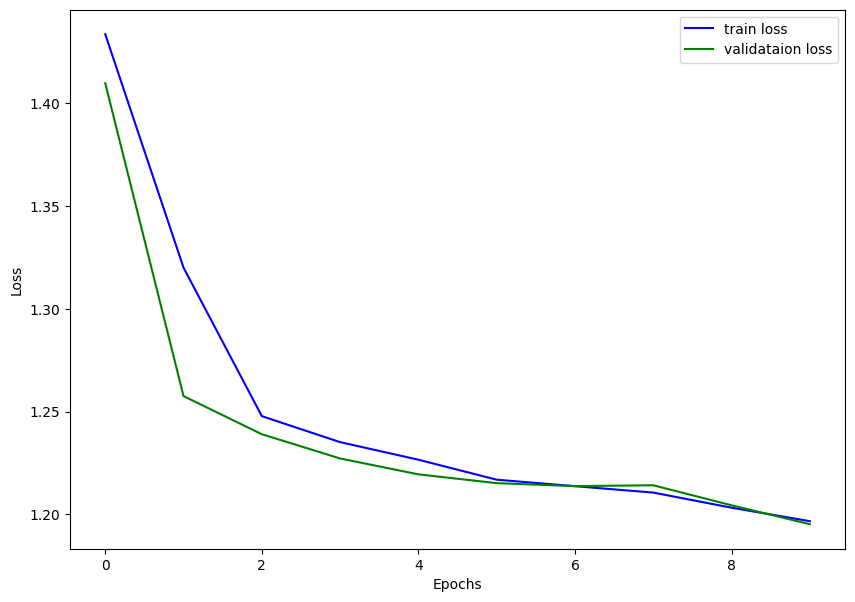

In [38]:
# save the reconstructions as a .gif file
to_pil(image_grid)
# save the loss plots
loss_plot(train_loss, valid_loss)